<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/Updated_EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Install a newer version of matplotlib if needed
!pip install matplotlib==3.8.0

# Data processing
import pandas as pd
import numpy as np

# Train/test split and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Thay MinMaxScaler bằng StandardScaler

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import matplotlib.pyplot as plt

# Neural network visualization
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Completed")

# Print current directory to verify
!pwd

Completed
/content


# Entity Embedding Training

Cell 2: Tải và Kiểm Tra Dataset

In [56]:
# List of columns to keep from autos.csv
cols_to_keep = [
    'price',              # Target variable
    'brand',              # Categorical variable for embedding
    'model',              # Categorical variable for embedding
    'vehicleType',        # Categorical variable for embedding
    'fuelType',           # Categorical variable for embedding
    'gearbox',            # Categorical variable for dummy encoding
    'kilometer',          # Numeric variable
    'powerPS',            # Numeric variable
    'yearOfRegistration', # Numeric variable
    'monthOfRegistration',# Numeric variable
    'nrOfPictures',       # Numeric variable
    'postalCode',         # Now treated as categorical
    'dateCreated'         # To extract adYear
]

# Read data from autos.csv (adjust path as needed)
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

# Show first 5 rows
print("First 5 rows of the dataset:")
print(data.head())

# Display dataset info
print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand          dateCreated  \
0     150000                    0   benzin  volkswagen  2016-03-24 00:00:00   
1     125000                    5   diesel        audi  2016-03-24 00:00:00   
2     125000                    8   diesel        jeep  2016-03-14 00:00:00   
3     150000                    6   benzin  volkswagen  2016-03-17 00:00:00   
4      90000                    7   diesel       skoda  2016-03-31 00:00:00   

   nrOfPictures  postalCode  
0             0       70435  
1        

Cell 3: Tiền Xử Lý Dữ Liệu

In [57]:
# Extract year from dateCreated
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data = data.drop(columns=['dateCreated'])

# Define categorical and numerical columns
categorical_cols = ['brand', 'model', 'vehicleType', 'fuelType', 'postalCode', 'gearbox']
numerical_cols = ['kilometer', 'powerPS', 'yearOfRegistration', 'monthOfRegistration', 'nrOfPictures', 'adYear']

# Impute missing values: median for numeric, 'missing' for categorical
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())
for col in categorical_cols:
    data[col] = data[col].fillna('missing').astype(str)

# Loại bỏ các mẫu có price = 0 hoặc nhỏ hơn 0
data = data[data['price'] > 0]

# Cap outliers using percentiles for price and kilometer
for col in ['price', 'kilometer']:
    lower_bound = data[col].quantile(0.01)  # 1% percentile
    upper_bound = data[col].quantile(0.99)  # 99% percentile
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Normalize numerical data using MinMaxScaler
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Normalize price separately
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])

# Display first 5 rows after preprocessing
print("\nFirst 5 rows after preprocessing:")
print(data.head())

# Dataset info after processing
print("\nDataset info after processing:")
print(data.info())

<ipython-input-57-e7727421bd63>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-57-e7727421bd63>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)



First 5 rows after preprocessing:
      price vehicleType  yearOfRegistration    gearbox  powerPS    model  \
0  0.010168     missing            0.110346    manuell  0.00000     golf   
1  0.499863       coupe            0.112346    manuell  0.00950  missing   
2  0.266282         suv            0.111568  automatik  0.00815    grand   
3  0.038197  kleinwagen            0.111235    manuell  0.00375     golf   
4  0.095905  kleinwagen            0.112012    manuell  0.00345    fabia   

   kilometer  monthOfRegistration fuelType       brand  nrOfPictures  \
0   1.000000             0.000000   benzin  volkswagen           0.0   
1   0.827586             0.416667   diesel        audi           0.0   
2   0.827586             0.666667   diesel        jeep           0.0   
3   1.000000             0.500000   benzin  volkswagen           0.0   
4   0.586207             0.583333   diesel       skoda           0.0   

  postalCode  adYear  
0      70435     1.0  
1      66954     1.0  
2     

Cell 4: Train-Test Split and Prepare Inputs

In [58]:
# Features and target
X = data.drop(['price'], axis=1).copy()
y = data['price']

# Split into train_val and test (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train_val into train and validation (80% train, 20% validation of train_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Check number of records
print(f'\nTraining set: {X_train.shape[0]} records with {X_train.shape[1]} columns.')
print(f'Validation set: {X_val.shape[0]} records with {X_val.shape[1]} columns.')
print(f'Test set: {X_test.shape[0]} records with {X_test.shape[1]} columns.')


Training set: 230880 records with 12 columns.
Validation set: 57720 records with 12 columns.
Test set: 72150 records with 12 columns.


Cell 5: Prepare Numerical Inputs and Build Model

In [59]:
# Encode categorical variables for embedding
cat_encoders = {}
embedding_dims = {}
for col in categorical_cols:
    unique_cat = np.unique(X_train[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    X_train[col] = X_train[col].map(cat_encoders[col]).astype(np.int32)
    X_val[col] = X_val[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    X_test[col] = X_test[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    embedding_dims[col] = min(50, int(np.sqrt(len(unique_cat))))

# Prepare input lists for train, validation, and test sets
input_list_train = [X_train[col].values for col in categorical_cols] + [X_train[numerical_cols].values]
input_list_val = [X_val[col].values for col in categorical_cols] + [X_val[numerical_cols].values]
input_list_test = [X_test[col].values for col in categorical_cols] + [X_test[numerical_cols].values]

# Convert targets to float32
y_train = y_train.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

Cell 6: Compile and Train the Model


Model summary for the optimized EE model (v4):


Model: "Enhanced_EE_FNN_Optimized_v4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_brand (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_model (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_vehicleType         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_fuelType            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_postalCode          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gearbox             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_brand (Embedding)     │ (None, 1, 6)           │            240 │ input_brand[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_model (Embedding)     │ (None, 1, 15)          │          3,750 │ input_model[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_vehicleType           │ (None, 1, 3)           │             27 │ input_vehicleType[0][… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_fuelType (Embedding)  │ (None, 1, 2)           │             16 │ input_fuelType[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_postalCode            │ (None, 1, 50)          │        403,650 │ input_postalCode[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_gearbox (Embedding)   │ (None, 1, 1)           │              3 │ input_gearbox[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, 6)              │              0 │ emb_brand[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_25 (Reshape)      │ (None, 15)             │              0 │ emb_model[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_26 (Reshape)      │ (None, 3)              │              0 │ emb_vehicleType[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_27 (Reshape)      │ (None, 2)              │              0 │ emb_fuelType[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape) 

 Total params: 429,703 (1.64 MB)

 Trainable params: 429,255 (1.64 MB)

 Non-trainable params: 448 (1.75 KB)

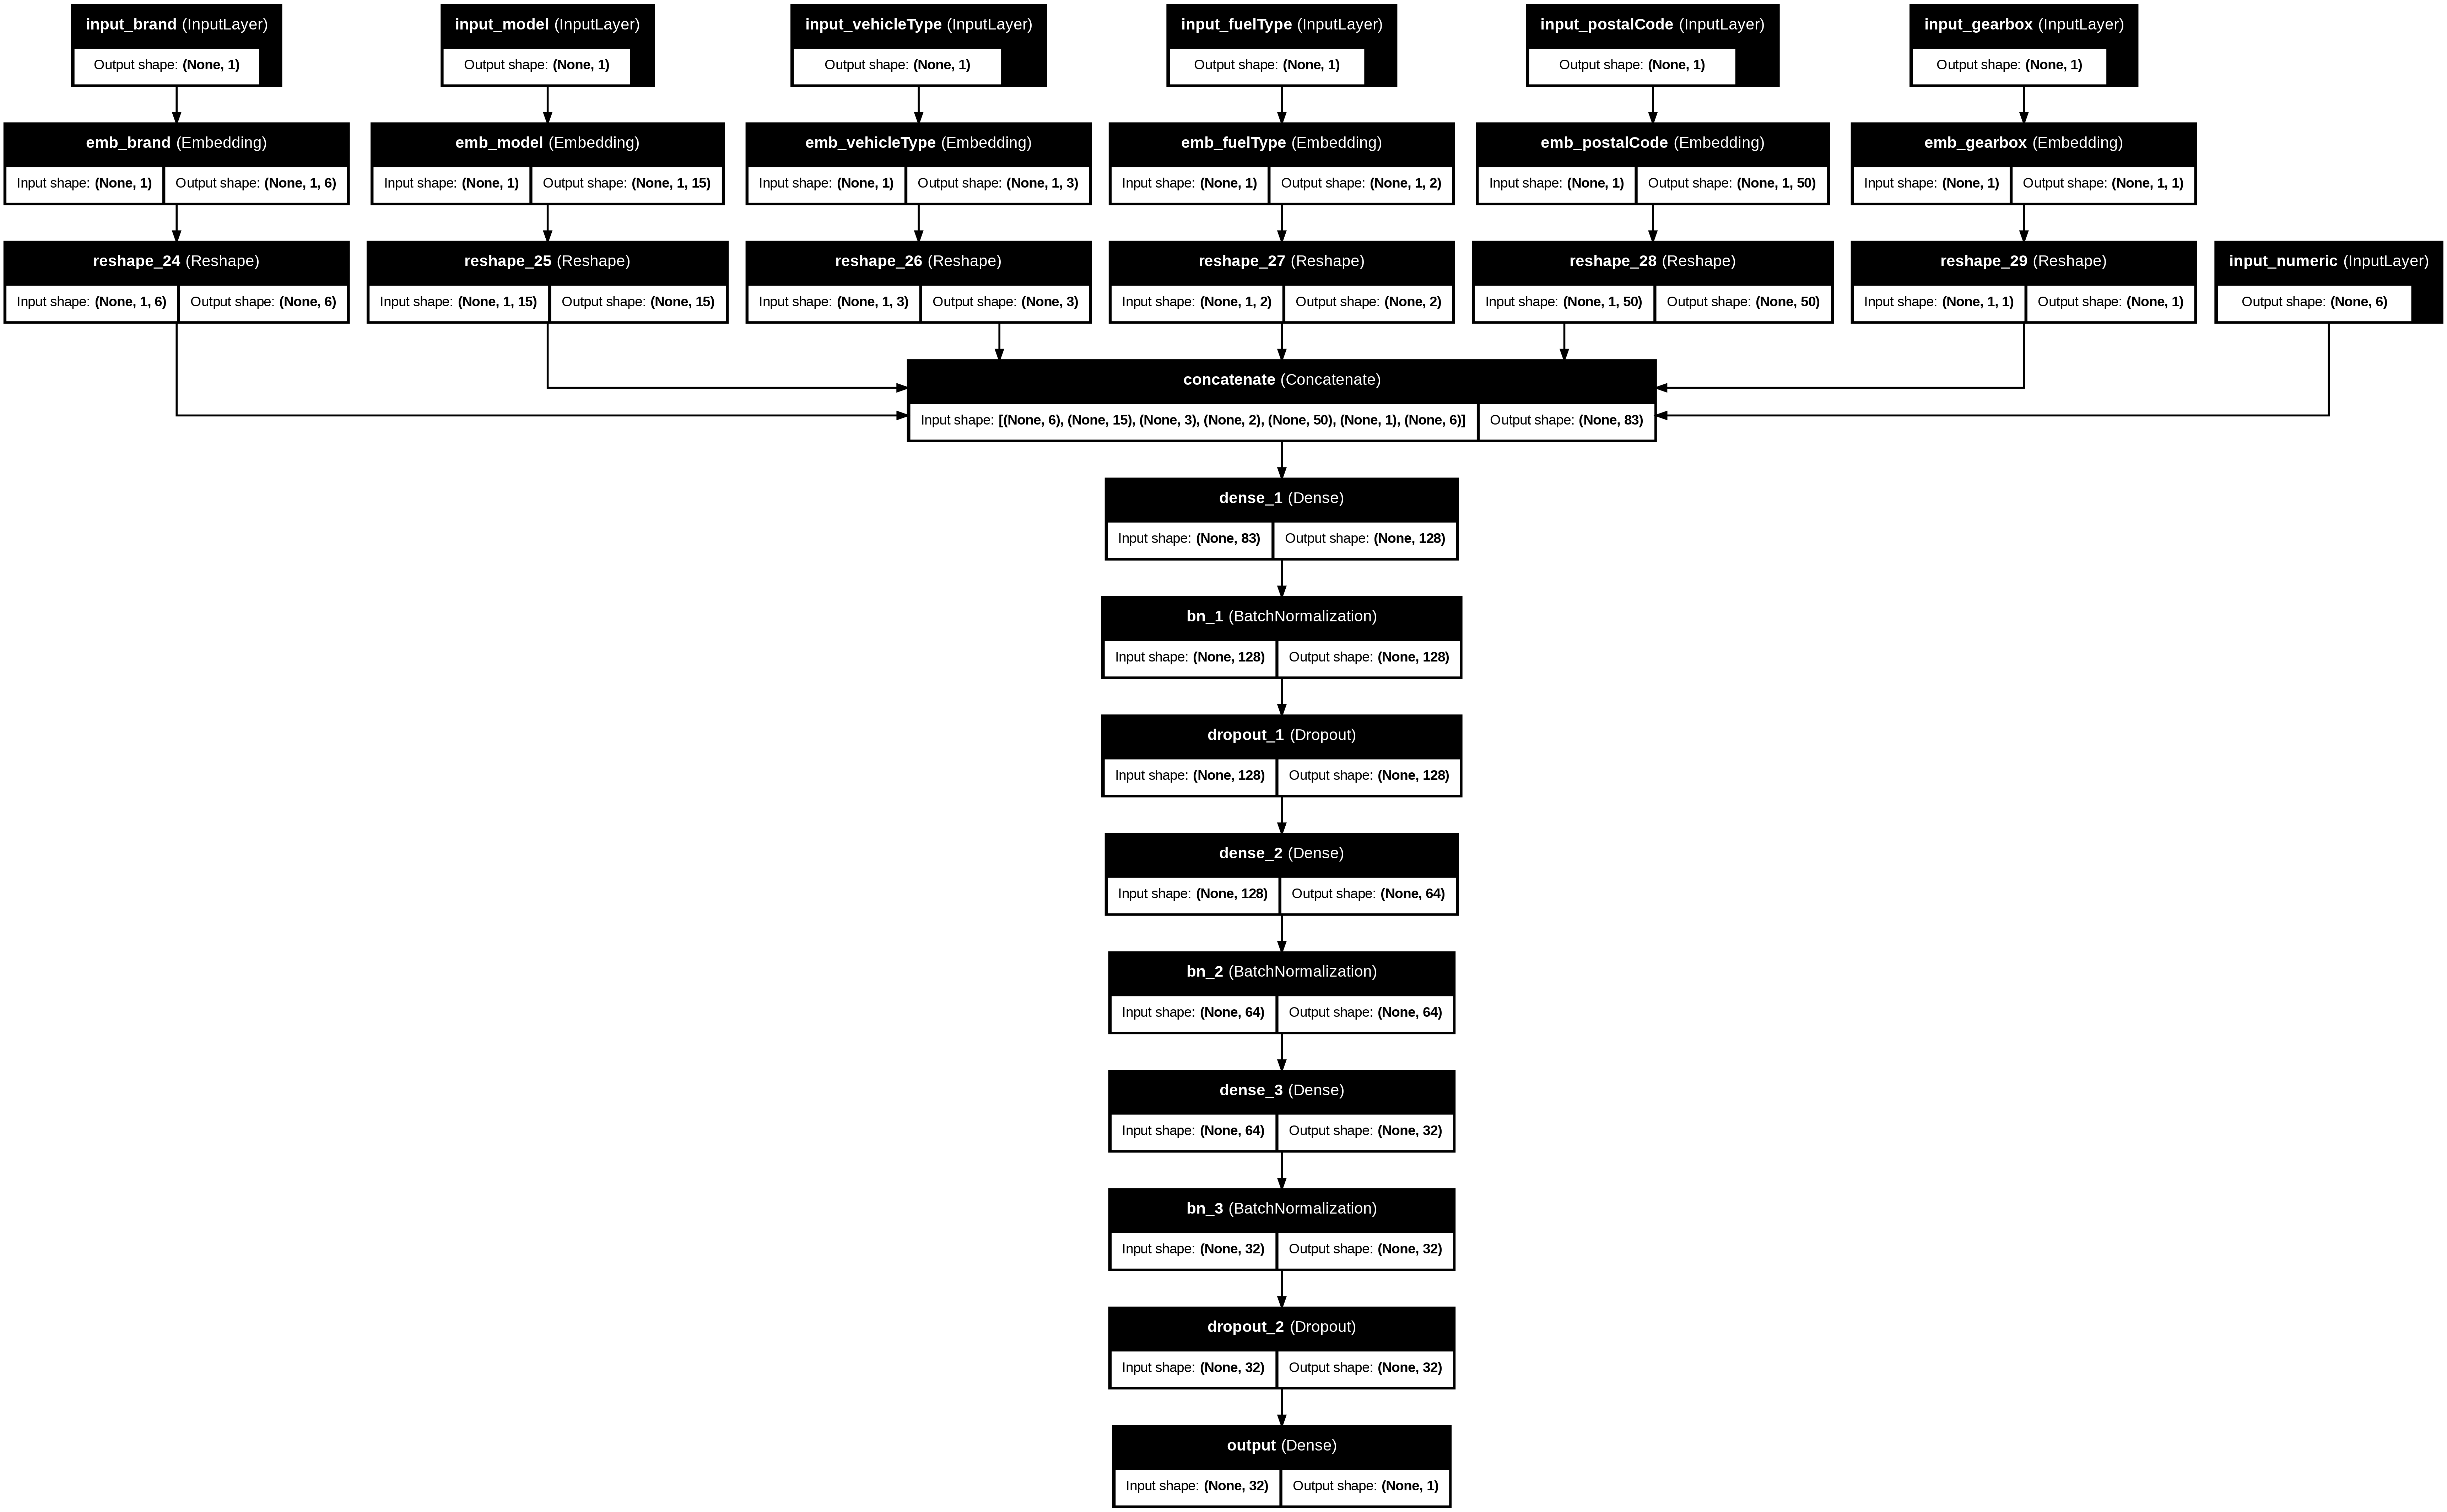

In [60]:
from tensorflow.keras.regularizers import l2

# Regularization parameter
l2_reg = 0.001

# Define inputs and embedding layers for categorical variables
inputs = []
embeddings = []
for col in categorical_cols:
    input_cat = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(input_dim=len(np.unique(X_train[col])), output_dim=embedding_dims[col], name=f'emb_{col}')(input_cat)
    emb = Reshape(target_shape=(embedding_dims[col],))(emb)
    inputs.append(input_cat)
    embeddings.append(emb)

# Define input for numerical variables
input_numeric = Input(shape=(len(numerical_cols),), name='input_numeric')
inputs.append(input_numeric)

# Concatenate all embeddings and numerical input
combined = Concatenate(name='concatenate')(embeddings + [input_numeric])

# Build neural network layers with BN and L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_1')(combined)
x = BatchNormalization(name='bn_1')(x)
x = Dropout(0.2, name='dropout_1')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_2')(x)
x = BatchNormalization(name='bn_2')(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_3')(x)
x = BatchNormalization(name='bn_3')(x)
x = Dropout(0.2, name='dropout_2')(x)

# Output layer (linear activation for regression)
outputs = Dense(1, activation='linear', name='output')(x)

# Create the model
nn = Model(inputs=inputs, outputs=outputs, name='Enhanced_EE_FNN_Optimized_v4')

# Model summary
print("\nModel summary for the optimized EE model (v4):")
nn.summary()

# Visualize the model architecture
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Enhanced_EE_FNN_Optimized_v4.png')
Image(retina=True, filename='Enhanced_EE_FNN_Optimized_v4.png')

Cell 7: Make Predictions and Evaluate

Epoch 1/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 1.2400 - mae: 0.7558 - val_loss: 0.2242 - val_mae: 0.1529 - learning_rate: 1.0000e-04
Epoch 2/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.4157 - mae: 0.3669 - val_loss: 0.1828 - val_mae: 0.1087 - learning_rate: 1.0000e-04
Epoch 3/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.2452 - mae: 0.2287 - val_loss: 0.1435 - val_mae: 0.0840 - learning_rate: 1.0000e-04
Epoch 4/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.1522 - mae: 0.1361 - val_loss: 0.0988 - val_mae: 0.0751 - learning_rate: 1.0000e-04
Epoch 5/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0917 - mae: 0.0915 - val_loss: 0.0542 - val_mae: 0.0739 - learning_rate: 1.0000e-04
Epoch 6/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0473 - mae: 0.0786 - val_loss: 0.0266 - val_mae: 0.0727 - learning_rate: 1.0000e-04
Epoch 7/300
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0241 - mae: 0.0754 - val_loss: 0

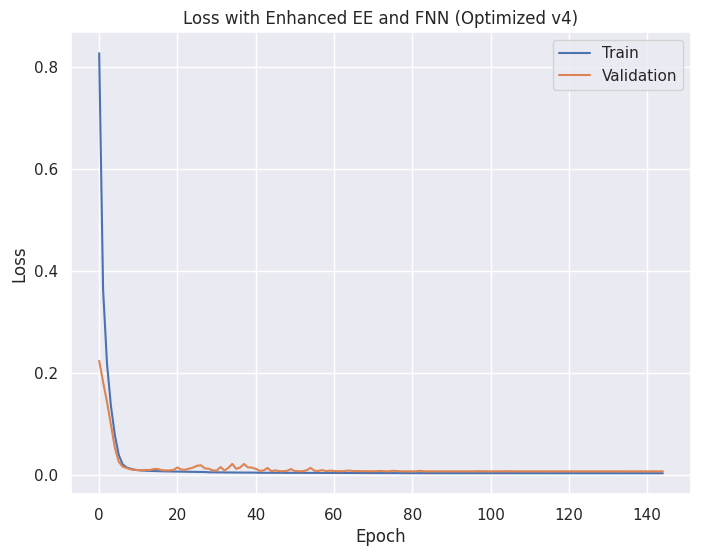

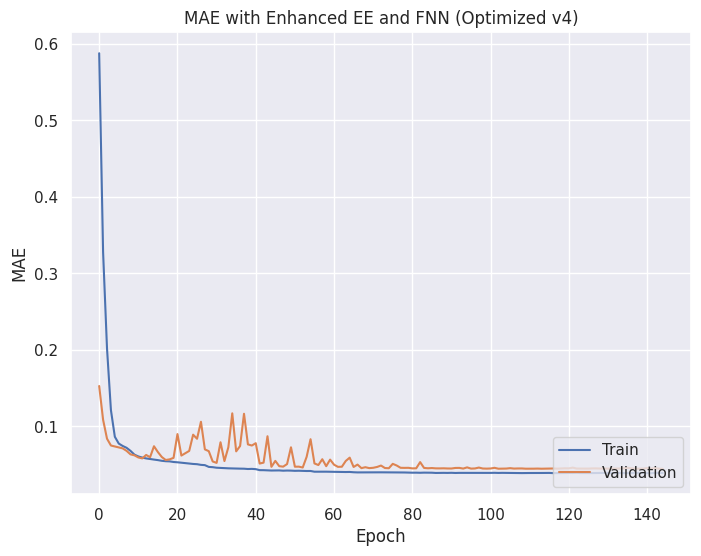

In [61]:
# Compile the model
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

# Set up early stopping with patience = 30
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

# Set up learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Train the model for up to 300 epochs
history = nn.fit(
    input_list_train,
    y_train,
    validation_data=(input_list_val, y_val),
    epochs=300,
    batch_size=128,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Enhanced EE and FNN (Optimized v4)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE with Enhanced EE and FNN (Optimized v4)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Cell 8: Prediction, Evaluation & Residuals Plot

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


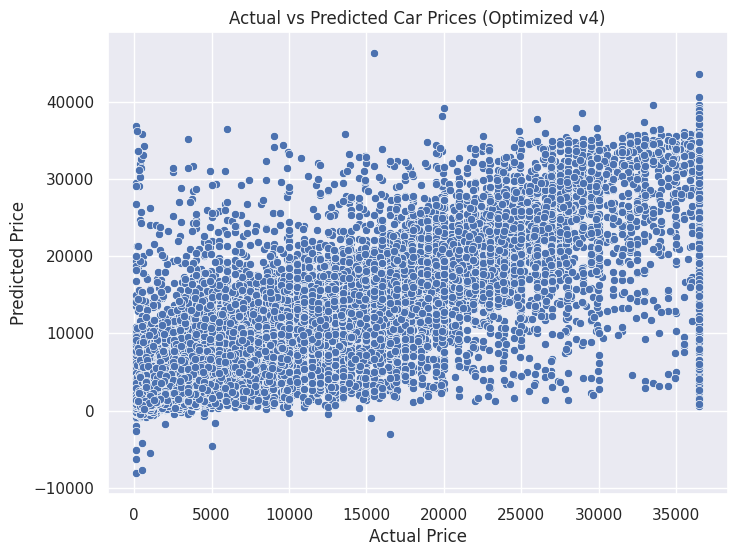

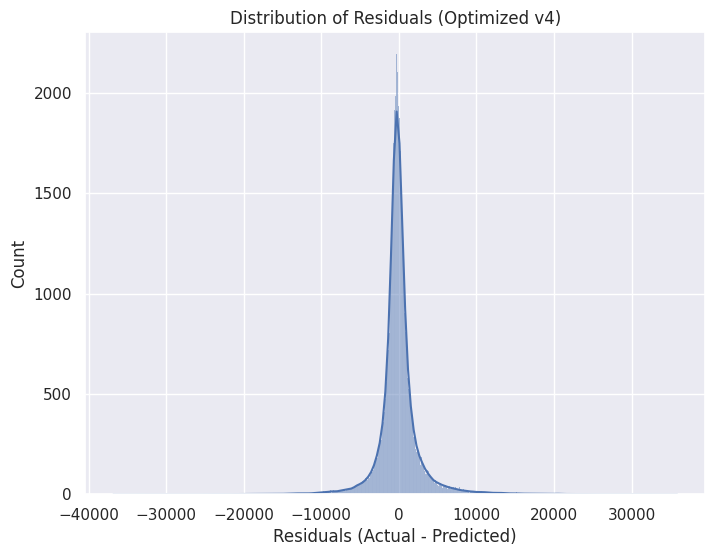


The MSE for the model is 9301428.00
The RMSE for the model is 3049.82.
The MAE for the model is 1606.83.
The R-squared for the model is 0.80.
The MAPE for the model is 0.80.
The SMAPE for the model is 0.39.


In [62]:
# Generate predictions on the test set
y_test_predict = nn.predict(input_list_test)

# Inverse transform predictions and true values to original scale
y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Flatten predictions if necessary
y_test_predict = y_test_predict.flatten()

# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices (Optimized v4)')
plt.show()

# Calculate residuals
residuals = y_test - y_test_predict

# Plot histogram of residuals with KDE
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Distribution of Residuals (Optimized v4)')
plt.show()

# Compute evaluation metrics
MSE = np.mean(residuals**2)
RMSE = np.sqrt(MSE)
MAE_val = np.mean(np.abs(residuals))
R2 = 1 - np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2)

# Tính MAPE với epsilon để tránh chia cho 0
epsilon = 1e-10
MAPE = np.mean(np.abs(residuals / (y_test + epsilon)))

# Tính SMAPE như một chỉ số thay thế
SMAPE = np.mean(2 * np.abs(residuals) / (np.abs(y_test) + np.abs(y_test_predict)))

print(f'\nThe MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE_val:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')
print(f'The SMAPE for the model is {SMAPE:.2f}.')

Cell 9: Make input for MLP

In [64]:
# Tạo một mô hình mới để trích xuất embedding từ các lớp Embedding
embedding_models = {}
for i, col in enumerate(categorical_cols):
    # Lấy lớp embedding tương ứng với biến phân loại
    embedding_layer = nn.get_layer(f'emb_{col}')
    # Tạo mô hình trích xuất embedding, sử dụng đúng đầu vào tương ứng
    embedding_models[col] = Model(inputs=nn.input[i], outputs=embedding_layer.output)

# Trích xuất embedding cho tập huấn luyện, kiểm tra và validation
embeddings_train = []
embeddings_val = []
embeddings_test = []

for col in categorical_cols:
    # Trích xuất embedding cho tập huấn luyện
    emb_train = embedding_models[col].predict(input_list_train[categorical_cols.index(col)])
    # Loại bỏ chiều thứ 2 (chiều 1) để có mảng 2D
    emb_train = emb_train.reshape(emb_train.shape[0], -1)
    embeddings_train.append(emb_train)

    # Trích xuất embedding cho tập validation
    emb_val = embedding_models[col].predict(input_list_val[categorical_cols.index(col)])
    emb_val = emb_val.reshape(emb_val.shape[0], -1)
    embeddings_val.append(emb_val)

    # Trích xuất embedding cho tập kiểm tra
    emb_test = embedding_models[col].predict(input_list_test[categorical_cols.index(col)])
    emb_test = emb_test.reshape(emb_test.shape[0], -1)
    embeddings_test.append(emb_test)

# Kết hợp các embedding với các biến số
# input_list_train[-1], input_list_val[-1], input_list_test[-1] là các biến số
X_train_mlp = np.hstack(embeddings_train + [input_list_train[-1]])
X_val_mlp = np.hstack(embeddings_val + [input_list_val[-1]])
X_test_mlp = np.hstack(embeddings_test + [input_list_test[-1]])

# In kích thước của dữ liệu đầu vào cho MLP
print(f"X_train_mlp shape: {X_train_mlp.shape}")
print(f"X_val_mlp shape: {X_val_mlp.shape}")
print(f"X_test_mlp shape: {X_test_mlp.shape}")

7215/7215 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 2s 963us/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 7s 942us/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 7s 985us/step
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step
X_train_mlp shape: (230880, 83)
X_val_mlp shape: (57720, 83)
X_test_mlp shape: (72150, 83)


# MLP Training